<a href="https://colab.research.google.com/github/RayGone/DeepWeeds/blob/ViT/ViT/Tiny_ViT/Experiment3_DeepWeeds_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4419124%2F7615277%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T114314Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D741c6f5206e66c44d93457991b3393438f412df142a073be8c65fb2afb3e11f738b6df56a51d662db58a28ca678140aeacf908491aed0ddbd4e68cd62e8c02be9893224b472d328c9c77313b0f8257e8f47dd33272f1aa63021db24f1130f2be15e56fdb19172e074c1c7f2be58db2051abd7a39a7625d9403c1d044d561dcb8dfff9e510bfd06c226d3e85893c1b3df0466d7b0e41d1bbe450ce3bc84889393205bb341049189835dc89e84aae8c516bb3104bdb1773b5d72d1bd06fe8b6d274c00276d75fe4be863485ab4c090a4b57d6ef3b06b63a87847d47061ad725e951baa24643cd351c5783d97f4f8b8c6567354788cf5b8c87b48c24546e0640f41'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 493010412 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# DeepWeeds Preprocessing

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil
import random

###=====================
###= Global Configs ===
###===================
SEED = 999
IMG_SIZE = (224,224,3)
OVERSAMPLING = 0 # How many times are we gonna over sample
KFOLD_INDEX = 2

TRAIN_BATCH = 32
TEST_BATCH = 16

MODEL_INDEX = 0
BASE_MODELS = ['WinKawaks/vit-tiny-patch16-224', 'WinKawaks/vit-small-patch16-224', 'google/vit-base-patch16-224']

EPOCHS_1 = 2 # for Non Augmented Data
EPOCHS_2 = 10 # for Augmented Data
LR = 1e-4 # Learning Rate
WDR = 4e-3 # Weight Decay Rate
FIN_LR = 1e-6 # Final LR

MODEL_NAME = "DeepWeeds-KI"+str(KFOLD_INDEX+1)+"-"+BASE_MODELS[MODEL_INDEX].split("/")[1].upper()
USE_AUGMENT = True

In [3]:
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

    if deterministic:
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(SEED)

# if tf.config.list_logical_devices('GPU'):
#     print("GPU")
#     tf.keras.mixed_precision.set_global_policy("float32")

In [4]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [5]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/labels.csv") ## For Kaggle
data_info

Filename  Label       Species
0      20160928-140314-0.jpg      0  Chinee apple
1      20160928-140337-0.jpg      0  Chinee apple
2      20160928-140731-0.jpg      0  Chinee apple
3      20160928-140747-0.jpg      0  Chinee apple
4      20160928-141107-0.jpg      0  Chinee apple
...                      ...    ...           ...
17504  20180322-133822-1.jpg      8      Negative
17505  20180322-133832-1.jpg      8      Negative
17506  20180322-133840-1.jpg      8      Negative
17507  20180322-133850-1.jpg      8      Negative
17508  20180322-133901-1.jpg      8      Negative

[17509 rows x 3 columns]

In [6]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species  Chinee apple  Lantana  Negative  Parkinsonia  Parthenium  \
Label            1125     1064      9106         1031        1022   

Species  Prickly acacia  Rubber vine  Siam weed  Snake weed  
Label              1062         1009       1074        1016

In [7]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label, label2id

({0: 'Chinee apple',
  1: 'Lantana',
  8: 'Negative',
  2: 'Parkinsonia',
  3: 'Parthenium',
  4: 'Prickly acacia',
  5: 'Rubber vine',
  6: 'Siam weed',
  7: 'Snake weed'},
 {'Chinee apple': 0,
  'Lantana': 1,
  'Negative': 8,
  'Parkinsonia': 2,
  'Parthenium': 3,
  'Prickly acacia': 4,
  'Rubber vine': 5,
  'Siam weed': 6,
  'Snake weed': 7})

In [8]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:40:40)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = KFOLD_INDEX # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [10]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = prediction[low_data_labels]
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5,labels=list(range(9)), target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names, n_class=len(label_names)))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen , use_rand_guess=False):
    #     print("model.evaluate")
    #     model.evaluate(data_gen)
    print("model.predict")
    actual_labels = []
    pred_prob = []

    for batch in tqdm(data_gen):
        actual_labels.extend([x for x in batch[1]])
        pred_prob.extend(model(batch[0]).logits)

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))
    print("Total Epochs:",epochs)

    if('accuracy' in history):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        plt.figure(figsize=[16, 4])
        if 'loss' in history:
            plt.subplot(1,2,1)
        plt.plot(epochs, acc, label='Training accuracy', color='red')
        plt.plot(epochs, val_acc, label='Validation accuracy', color='orange')
        plt.title('Training and validation accuracy')
        plt.legend()

    if("loss" in history):
        if 'accuracy' not in history:
            plt.figure(figsize=[16, 4])
        else:
            plt.subplot(1,2,2)
        plt.plot(epochs, loss, label='Training Loss', color='red')
        plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
        plt.title('Training and validation loss')
        plt.legend()

    plt.show()

# Augmentation

In [13]:
from tensorflow.keras import layers

class ImageNormalize(layers.Layer):
    def __init__(self, mean=0.5, std=0.5, transpose=True, **kwargs):
        super(ImageNormalize,self).__init__(**kwargs)
        self.mean = mean
        self.std = std

    def call(self, x, training=True):
        perm = (0, 3, 1, 2)
        x = (x - self.mean) / self.std
        x = tf.transpose(x, perm=perm)
        return x


normalize = ImageNormalize()

###==============================
## Augmentation Pipeline Model==
###============================
augment = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMG_SIZE),
    layers.RandomBrightness(0.3, (0, 255),seed=SEED),
    layers.RandomContrast(0.3, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.5, seed=SEED),
    layers.RandomTranslation(0.4, 0.4, seed=SEED),
    layers.RandomZoom(0.1, 0.1, seed=SEED),
    layers.GaussianDropout(0.01, seed=SEED),
], name='image_augment_pipeline')

preprocess = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMG_SIZE),
    layers.Rescaling(1./255),
    layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    ImageNormalize(),
], name='image_preprocess_pipeline')

augment.summary()

Model: "image_augment_pipeline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 224, 224, 3)       0         
 Translation)                               

# Creating Dateset ImageGenerator

In [14]:
%%time

if OVERSAMPLING:
    print("Oversampling",OVERSAMPLING,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/images" ## For Kaggle #"/kaggle/input/deepweeds/images"
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=OVERSAMPLING, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 3.18 s, sys: 2.17 s, total: 5.35 s
Wall time: 6.09 s


In [15]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=TRAIN_BATCH,
      label_mode='int',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=TEST_BATCH,
      label_mode='int',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=TEST_BATCH,
      label_mode='int',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10506 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.


In [16]:
def trainer():
    for x, y in train_generator:
        x = augment(x,True)
        x = preprocess(x, True)
        yield x, y

def processor(x,y):
    x = preprocess(x, True)
    return x, y

sampler = train_generator.take(2)
validation_generator = validation_generator.map(processor, num_parallel_calls=4)
test_generator = test_generator.map(processor, num_parallel_calls=4)

# Sample Images


Dataset Sample Images Visualization


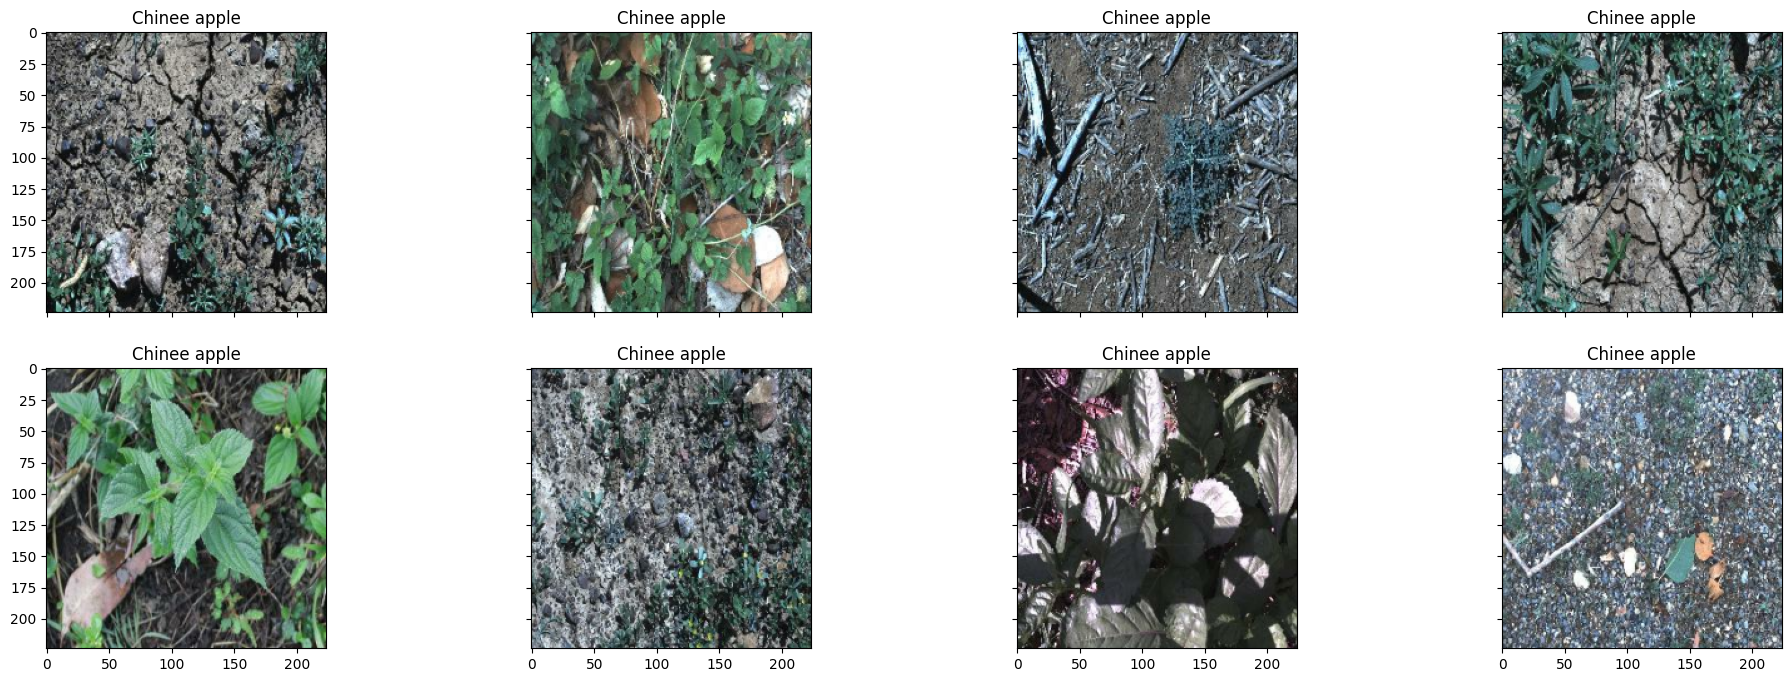


Augmentation Sample Visualization


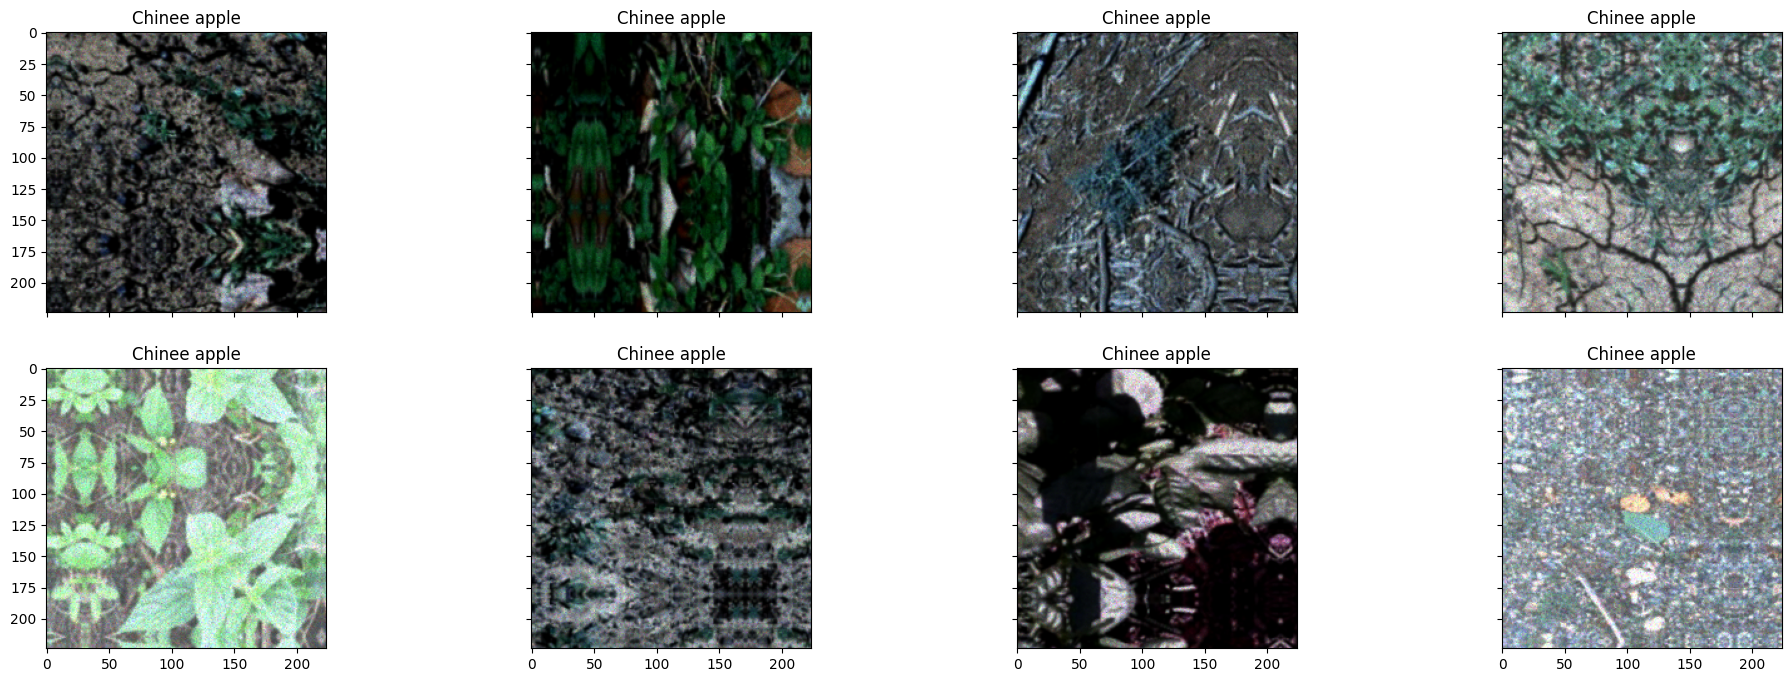

In [17]:
#image visualization
import matplotlib.pyplot as plt

print()
print("Dataset Sample Images Visualization")
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))
for images, labels in sampler:
    images = np.asarray(images).astype(np.int32)
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2])
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

print()
print("Augmentation Sample Visualization")
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

images = augment(images, training=True) ###* 0.5) + 0.5 ## UnNormalize The Image
# images = tf.clip_by_value(images, 0 ,1) * 255
for i in range(2):
    for j in range(4):
        ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
        ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

plt.show()

# Building Model

In [18]:
from transformers import ViTImageProcessor, TFViTForImageClassification, TFViTModel, TFAutoModel, AutoImageProcessor

print(BASE_MODELS[MODEL_INDEX])

model = TFViTForImageClassification.from_pretrained(BASE_MODELS[MODEL_INDEX],
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    hidden_dropout_prob=0.2,
                                                   ignore_mismatched_sizes=True)
model.summary()
model.config

WinKawaks/vit-tiny-patch16-224


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch 

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  5524416   
                                                                 
 classifier (Dense)          multiple                  1737      
                                                                 
Total params: 5526153 (21.08 MB)
Trainable params: 5526153 (21.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ViTConfig {
  "_name_or_path": "WinKawaks/vit-tiny-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.2,
  "hidden_size": 192,
  "id2label": {
    "0": "Chinee apple",
    "1": "Lantana",
    "2": "Parkinsonia",
    "3": "Parthenium",
    "4": "Prickly acacia",
    "5": "Rubber vine",
    "6": "Siam weed",
    "7": "Snake weed",
    "8": "Negative"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 768,
  "label2id": {
    "Chinee apple": 0,
    "Lantana": 1,
    "Negative": 8,
    "Parkinsonia": 2,
    "Parthenium": 3,
    "Prickly acacia": 4,
    "Rubber vine": 5,
    "Siam weed": 6,
    "Snake weed": 7
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 3,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": 

# Model Training - Trial 1

In [20]:
from transformers import create_optimizer, AdamWeightDecay
ratio = FIN_LR / LR

length = len(train_generator)
warmup_steps = length // 2
train_steps =  length * EPOCHS_2
loss = pd.DataFrame({'loss':[], 'val_loss':[]})

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
329/329 [==============================] - 168s 299ms/step - loss: 1.4768 - val_loss: 1.4332
Epoch 2/2
329/329 [==============================] - 83s 251ms/step - loss: 0.9634 - val_loss: 1.0186
Total Epochs: range(0, 2)


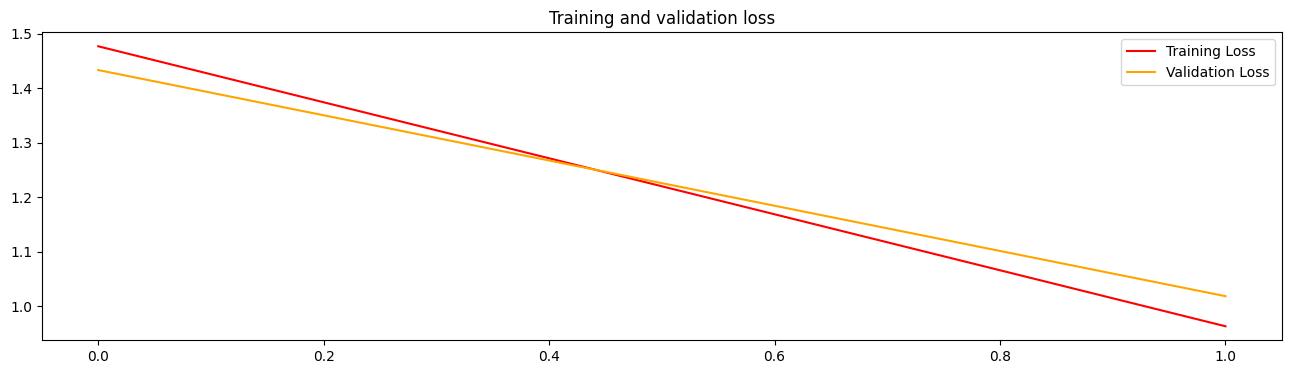

CPU times: user 4min 21s, sys: 22.8 s, total: 4min 44s
Wall time: 5min 10s


In [22]:
%%time
train = train_generator.map(processor, num_parallel_calls=4)

optimizer, schedule = create_optimizer(
    init_lr=LR,
    min_lr_ratio = ratio,
    num_warmup_steps=warmup_steps,
    num_train_steps=train_steps,
    power = 3,
    weight_decay_rate=WDR,
)

model.compile(optimizer=optimizer)

history = model.fit(
      train,
      epochs=EPOCHS_1,
      validation_data=validation_generator
    )

history = pd.DataFrame(history.history)
loss = pd.concat([loss,history])

# model.save(MODEL_NAME)
plot_loss_acc(loss)

model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.62651   0.23111   0.33766       225
       Lantana    0.94444   0.08019   0.14783       212
   Parkinsonia    0.39316   0.22330   0.28483       206
    Parthenium    0.76471   0.12683   0.21757       205
Prickly acacia    0.91667   0.36150   0.51852       213
   Rubber vine    0.52667   0.78218   0.62948       202
     Siam weed    0.40400   0.93953   0.56503       215
    Snake weed    0.50885   0.56650   0.53613       203
      Negative    0.75047   0.88193   0.81091      1821

      accuracy                        0.65648      3502
     macro avg    0.64839   0.46590   0.44977      3502
  weighted avg    0.69598   0.65648   0.61541      3502


                False Positive Rate  Accuracy
Chinee apple               0.009460  0.231111
Lantana                    0.000304  0.080189
Parkinsonia                0.021541  0.223301
Parthenium                 0.002426  0.126829
Prickly acacia    

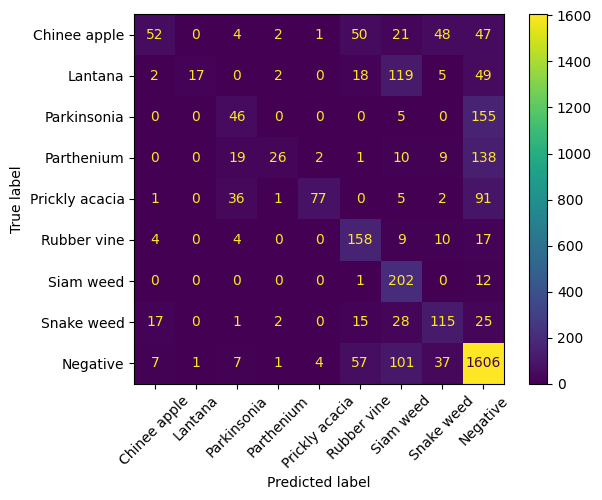

In [23]:
a, b = eval_model(model, validation_generator)

# Trial 2 - Augmentation

329/329 [==============================] - 99s 302ms/step - loss: 0.7623 - val_loss: 0.7942
Total Epochs: range(0, 12)


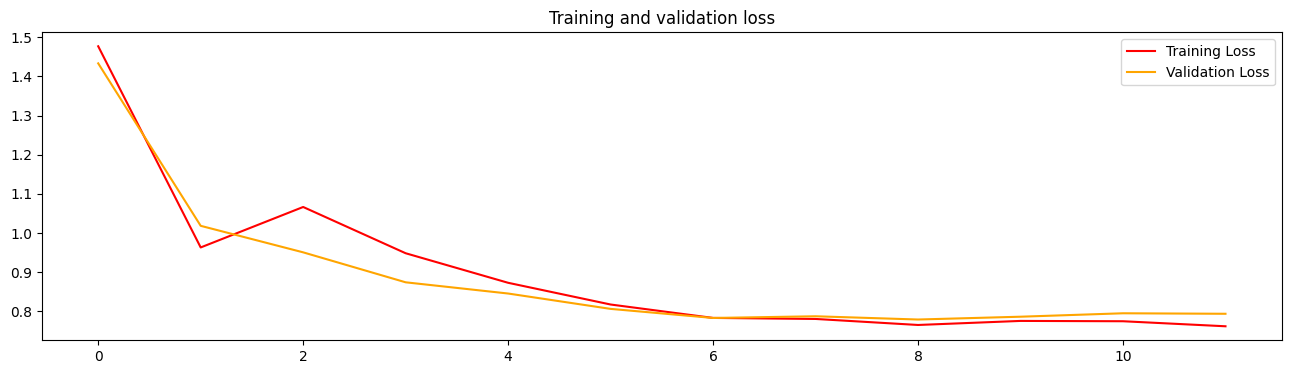

CPU times: user 19min 14s, sys: 1min 29s, total: 20min 44s
Wall time: 19min 47s


In [24]:
%%time
if USE_AUGMENT:
  for i in range(EPOCHS_2):
      history = model.fit(
            trainer(),
            epochs=1,
            validation_data=validation_generator
          )

      history = pd.DataFrame(history.history)
      loss = pd.concat([loss,history])

  # model.save(MODEL_NAME)
  plot_loss_acc(loss)

model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.73418   0.25778   0.38158       225
       Lantana    0.83117   0.30189   0.44291       212
   Parkinsonia    0.66892   0.48058   0.55932       206
    Parthenium    0.52560   0.75122   0.61847       205
Prickly acacia    0.60764   0.82160   0.69860       213
   Rubber vine    0.78199   0.81683   0.79903       202
     Siam weed    0.46114   0.82791   0.59235       215
    Snake weed    0.49129   0.69458   0.57551       203
      Negative    0.87132   0.82921   0.84975      1821

      accuracy                        0.72644      3502
     macro avg    0.66369   0.64240   0.61306      3502
  weighted avg    0.75953   0.72644   0.72060      3502


                False Positive Rate  Accuracy
Chinee apple               0.006408  0.257778
Lantana                    0.003951  0.301887
Parkinsonia                0.014867  0.480583
Parthenium                 0.042160  0.751220
Prickly acacia    

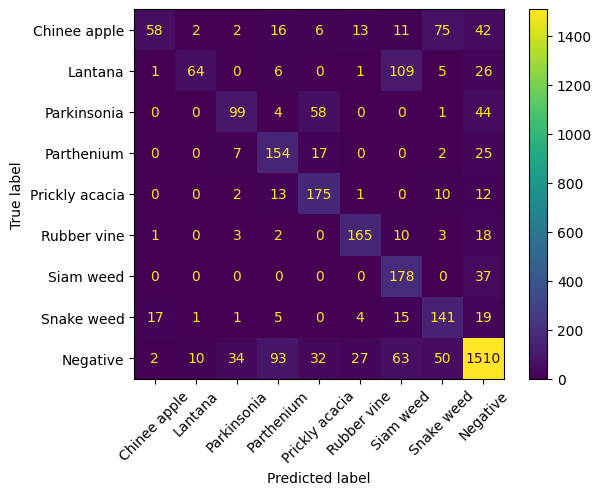

In [25]:
if USE_AUGMENT:
  a, b = eval_model(model, validation_generator)

# Evaluations

In [ ]:
thresholds = []

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

for i in range(len(a)):
    _b = b[i].numpy()
    n_label = prediction_argmax(_b)
    ap_label = np.argmax(_b)
    a_label = a[i].numpy()

    if(n_label != ap_label):
        thresholds.append(_b[n_label])

rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

In [ ]:
a, b = eval_model(model, test_generator)

In [ ]:
printStats([i.numpy() for i in a],[i.numpy() for i in b],rand_guess)

In [ ]:
shutil.rmtree(base_dir)